# 매출액 예측

## Load Data

In [1]:
from Package.loadfile import load

perform_df, rating_df, test_df = load()

## LSTM Forecasting (2020년 6월 한달 일별 매출액 예측)

In [9]:
# keras 설치
# pip install keras

In [2]:
perform_df['날짜'] = list(map(lambda i : i.date(), perform_df['방송일시']))

In [3]:
df = perform_df.groupby('날짜').sum()[' 취급액 '].reset_index()

In [4]:
# LSTM 데이터로 정제

import numpy as np
# 타임스텝
ts = 7

df[" 취급액 "] = df[' 취급액 '].map(lambda x : (x - df[' 취급액 '].mean()) / np.std(df[' 취급액 ']))
X_train = np.asarray([np.array([df[' 취급액 '].values[i+j] for j in range(ts)])
                      for i in range(len(df[' 취급액 ']) - ts)]).reshape(-1,ts,1)
y_train = df[' 취급액 '].values[ts:]
X_train.shape, y_train.shape

((359, 7, 1), (359,))

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_LSTM = Sequential()
model_LSTM.add(LSTM(100, input_shape=(ts, 1)))
model_LSTM.add(Dense(1, activation="linear"))
model_LSTM.compile(loss='mse', optimizer='adam')

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [6]:
import matplotlib.pyplot as plt

findfont: Font family ['BMJUA_ttf'] not found. Falling back to DejaVu Sans.
findfont: Font family ['BMJUA_ttf'] not found. Falling back to DejaVu Sans.


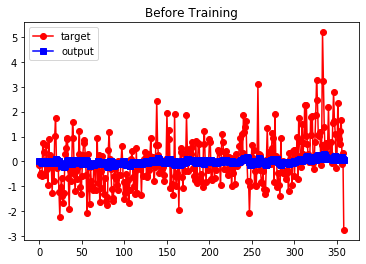

In [7]:
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("Before Training")
plt.show()

In [8]:
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=1000,verbose=0)

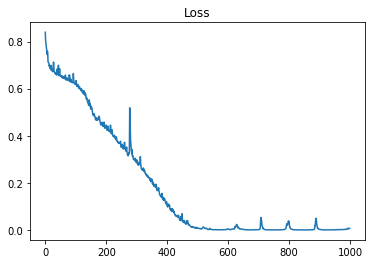

In [10]:
# Loss Graph
plt.plot(history_LSTM.history["loss"])
plt.title("Loss")
plt.show()

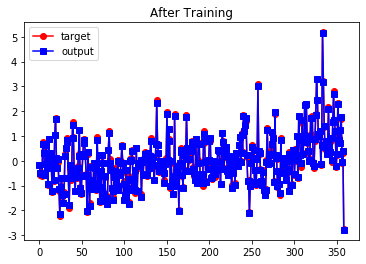

In [11]:
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("After Training")
plt.show()

In [15]:
y_values = model_LSTM.predict(X_train)[-7:]
new_value = model_LSTM.predict(y_values.reshape(-1,ts,1))


In [16]:
# 향후 180일 연속 예측
new_datas = []
for i in range(180):
    if i == 0:
        new_values = np.vstack((y_values,new_value))[-7:]
    else:
        new_values = np.vstack((new_values,new_value))[-7:]
    new_value = model_LSTM.predict(new_values.reshape(-1,ts,1))
    new_datas.append(new_value)

In [17]:
import itertools
final = list(itertools.chain(*new_datas))
final = list(itertools.chain(*final))

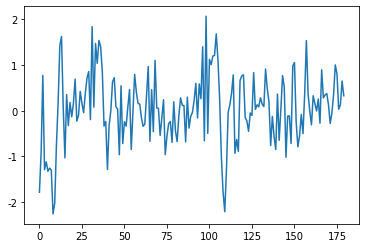

In [18]:
plt.plot(final)

## Feature 뽑아서 Layer 쌓고 Deep Learning 학습 (Feature - 매출액 or 판매량)

### Feature Tuning

In [ ]:
perform_df['시간대'] = list(map(lambda i : i.time().hour, perform_df['방송일시']))

In [ ]:
# 시청률

In [ ]:
rating_df.set_index('시간대', inplace=True)

In [ ]:
rating_df.loc['24:00'] = rating_df.loc['00:00']

In [ ]:
# 이전날짜 것으로 변경하면 같은날짜 24:00 으로 찾기 가능
rating_df.loc['24:00'][:-1] = rating_df.loc['00:00'][1:]

In [ ]:
# 확인용
rating_df.loc[['00:00', '24:00']]

In [ ]:
perform_df['평균시청률'] = list(map(lambda i : rating_df[str(i['방송일시'])[:10]][str(i['방송일시'])[11:16]:str(i['방송일시'] + timedelta(minutes = int(i['노출(분)'])))[11:16]].mean(), perform_df.iloc))

In [ ]:
perform_df.dropna(inplace=True)

In [ ]:
c_feature = perform_df['상품군'].unique()

In [ ]:
for c in c_feature:
    perform_df[c] = 0 

In [ ]:
category = list(perform_df['상품군'])

In [ ]:
for i,c in enumerate(category):
    perform_df[c][i] = 1

In [ ]:
perform_df.dropna(inplace=True)

In [ ]:
features = ['노출(분)','판매단가','평균시청률','시간대']
features.extend(list(c_feature))

In [ ]:
perform_df[features].isnull().sum()

In [ ]:
perform_df[features]

In [ ]:
import numpy as np
X_datas = np.matrix(perform_df[features])

In [ ]:
y_datas = np.array(perform_df[' 취급액 '])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_datas, y_datas, test_size=0.2, shuffle=True)

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [ ]:
# 딥러닝 모델링

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[15]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
history = model.fit(
  X_train, y_train,
  epochs=1000, validation_split = 0.2, verbose=0)

In [ ]:
pred = model.predict(X_train)

In [ ]:
# MSE
np.mean((y_train-pred)**2)

In [ ]:
plt.plot(y_train[:200])
plt.plot(pred[:200])
plt.show()

In [ ]:
# 검증 데이터 오차분포 (Scatter)

test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Sell]')
plt.ylabel('Predictions [Sell]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
# 검증 데이터 오차분포 (Bar)

error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## 모델 검증

In [ ]:
c_feature = test_df['상품군'].unique()

In [ ]:
for c in c_feature:
    test_df[c] = 0 

In [ ]:
features = ['노출(분)','판매단가','평균시청률','시간대']
features.extend(list(c_feature))

In [ ]:
test_df['시간대'] = list(map(lambda i : i.time().hour, test_df'방송일시']))

In [ ]:
test_df['평균시청률'] = 0

In [ ]:
forecast = np.matrix(test_df[features])

In [ ]:
test_df.drop('취급액', axis=1,inplace=True)

In [ ]:
for_pred = model.predict(forecast)

In [ ]:
test_df['취급액'] = for_pred

In [ ]:
# 무형, 0인 곳 채우기 위함 검증 데이터셋 Raw에 취급액 추가
test_raw['취급액'] = test_df['취급액']

In [ ]:
test_raw.fillna(0).to_csv('datas/result_data/result.csv')

## 참고용

In [ ]:
# 피처 튜닝
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


model = keras.Sequential([
    keras.layers.Layer(input_shape=(X_train.shape)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



model.fit(X_train, y_train, epochs=5)



test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\n테스트 정확도:', test_acc)